<a href="https://colab.research.google.com/github/VissaMoutafis/Time-Series-Processing-with-Tensorflow/blob/main/AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import argparse
import sys

sys.path.append('..')
import numpy as np
import pandas as pd

from keras import layers, optimizers, losses, metrics
from keras.models import Sequential
from keras import Model
from tensorflow.keras.optimizers import RMSprop
from keras.models import load_model

from sklearn.model_selection import train_test_split

from keras.layers.convolutional import Conv2D
from tensorflow.keras.layers import BatchNormalization
from keras.layers import MaxPooling2D
from keras.layers import UpSampling2D
from keras import Input

from keras.models import load_model

from matplotlib import pyplot as plt

import tensorflow as tf
	
import webbrowser

import torch

from torchtext.data.utils import get_tokenizer
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available else "cpu")
print(device)

np.random.seed(1)
torch.manual_seed(0)

cuda:0


In [16]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras import layers, models
from keras.callbacks import EarlyStopping

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
input_dataset_path = 'drive/MyDrive/Project-Datasets/nasd_input.csv'
query_dataset_path = 'drive/MyDrive/Project-Datasets/nasd_query.csv'
DATASET_SIZE = 1
LOOKBACK = 20

In [19]:
timeseries_df = pd.read_csv(input_dataset_path, sep='\t', index_col=0, header=None).astype(np.float32).sample(DATASET_SIZE)
TIME_SERIES_ID = timeseries_df.index.tolist()

In [20]:
mu = None
sigma = None
def normalize(dataset):
  return (dataset - mu)/sigma 

def reverse_normalize(dataset):
  return dataset*sigma + mu 

In [21]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

In [22]:
print(timeseries_df.to_numpy().shape)

(1, 730)


In [23]:
X_train, y_train = create_dataset(timeseries_df.to_numpy().reshape(-1),timeseries_df.to_numpy().reshape(-1),LOOKBACK)

In [24]:
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
print(X_train.shape)
y_train = y_train.reshape(-1)

(710, 20, 1)


In [25]:
def preprocess_dataset(df, lag=1):
  global sigma
  global mu
  dataset = df.to_numpy()
  
  if sigma is None: sigma = dataset.std()
  if mu is None: mu = dataset.mean()

  dataset = normalize(dataset)
  # divide the time series in input instances of X: #lag steps y: #lag+1-th value of the time series 
  # so we acquire #df * (complexity(df)-lag)
  X = None
  y = None
  for timeseries in dataset:
    X_i = None
    y_i = None 
    for i in range(lag, len(timeseries)):
      X_ij = np.asarray(timeseries[i-lag:i]).reshape((1, len(timeseries[i-lag:i]), 1))
      X_i = np.concatenate((X_i, X_ij)) if X_i is not None else X_ij
      y_ij = np.asarray(timeseries[i]).reshape((-1, 1))
      y_i = np.concatenate((y_i, y_ij)) if y_i is not None else y_ij
    
    X = np.concatenate((X, X_i), axis=-1) if X is not None else X_i
    y = np.concatenate((y, y_i), axis=-1) if y is not None else y_i

  return train_test_split(X, y, test_size=0.2)

In [47]:
class LSTMAutoEncoder(nn.Module):
    def __init__(self, input_dim, lstm_units, actv_fn, dropout=None, _optimizer='adam', _loss='mse'):
        super(LSTMAutoEncoder, self).__init__()
        self.history = {}
        self.D_train = None
        self.D_test = None
        self.lstm_units = lstm_units
        self.dropout = dropout
        self.optimizer = _optimizer
        self.loss = _loss
        self.input_dim = input_dim
        self.models = {}
        self.input_dim = input_dim      
        self.activation = nn.ReLU()
        self.device = device
        
        self.model = models.Sequential()
        #encoder loop
        for i, u in enumerate(self.lstm_units):
          if i == 0: 
            encoded = layers.LSTM(units=u, return_sequences=True, input_shape=self.input_dim)
            self.model.add(encoded)

          elif i == len(self.lstm_units) - 1:
            encoded = layers.LSTM(units=u)
            self.model.add(encoded)
            self.decoded = layers.RepeatVector(input_dim[0])

          else: 
            self.model.add(layers.LSTM(units=u, return_sequences=True))
          if self.dropout is not None:
            self.model.add(layers.Dropout(self.dropout))

        self.model.add(self.decoded)

        #decoder loop 
        for i, u in enumerate(self.lstm_units):
          if i == len(self.lstm_units) - 1:
            encoded = layers.LSTM(units=u,return_sequences=True)
            self.model.add(encoded)
          else: 
            self.model.add(layers.LSTM(units=u, return_sequences=True))
          if self.dropout is not None:
            self.model.add(layers.Dropout(self.dropout))

        # final output layer
        self.model.add(layers.TimeDistributed(layers.Dense(units=input_dim[-1])))
        
        self.model.compile(optimizer=self.optimizer, loss=self.loss)

    def fit(self, X, y, epochs=100, batch_size=128):
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
      self.D_train = X_train, y_train
      self.D_test = X_test, y_test
      self.history = self.model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1)
      return self.history

In [48]:
print(X_train.shape)
model = LSTMAutoEncoder(X_train.shape[1:],[50, 50,100],nn.ReLU,dropout=0.3)

(710, 20, 1)


In [49]:
model.fit(X_train, y_train, epochs=50)

Epoch 1/50
4/4 [==============================] - 12s 924ms/step - loss: 346.5406 - val_loss: 331.8066
Epoch 2/50
4/4 [==============================] - 1s 198ms/step - loss: 305.2110 - val_loss: 260.6688
Epoch 3/50
4/4 [==============================] - 1s 200ms/step - loss: 233.2160 - val_loss: 189.1213
Epoch 4/50
4/4 [==============================] - 1s 203ms/step - loss: 167.8773 - val_loss: 135.5679
Epoch 5/50
4/4 [==============================] - 1s 202ms/step - loss: 120.0868 - val_loss: 97.7979
Epoch 6/50
4/4 [==============================] - 1s 206ms/step - loss: 87.3366 - val_loss: 71.9497
Epoch 7/50
4/4 [==============================] - 1s 204ms/step - loss: 64.9471 - val_loss: 54.9214
Epoch 8/50
4/4 [==============================] - 1s 207ms/step - loss: 50.2789 - val_loss: 43.7124
Epoch 9/50
4/4 [==============================] - 1s 201ms/step - loss: 40.7058 - val_loss: 36.0890
Epoch 10/50
4/4 [==============================] - 1s 201ms/step - loss: 34.0840 - val_los

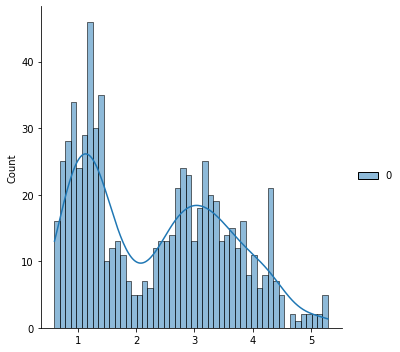

In [50]:
import seaborn as sns
X_train_pred = model.model.predict(X_train)

train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)
sns.displot(train_mae_loss, bins=50, kde=True);